In [1]:
#search for import above the current directory
import sys
import os
from pathlib import Path
cwd = Path().resolve()

sys.path.insert(1, os.path.join(cwd, 'Read Process CSV'))

import numpy as np
import pandas as pd
from tqdm import tqdm
import json
from scipy import stats

import dataAnalyzer_FTStat
import dataScreen_FTStat
import orbiStandardize

#Set up the inputs

#Folder with FT Statistic-ified files. All the files need to be processed using the same metrics.
folderPath = "Orbi_45k"
SmpStd = ['Std','F'] * 3 + ['Std'] + ['Std','C'] * 3 + ['Std'] + ['Std','I'] * 3 + ['Std'] +  ['Std','K'] * 3 + ['Std','M'] * 3 + ['Std','A'] * 3 + ['Std'] 
Replicate = ['1','1','2','2','3','3','4'] * 6 
fragmentDict = {'96':['18O','D','13C','Unsub']}

fragmentMostAbundant = ['Unsub']

massStr = []
fragmentIsotopeList = []
for i, v in fragmentDict.items():
    massStr.append(i)
    fragmentIsotopeList.append(v)
    
cullByTime = True
cullTimes = [(3,40)]

#Any specific properties you want to cull on
cullOn = "TIC*IT"
#Multiple of SD you want to cull beyond for the cullOn property
cull_amount = 3
#Whether you want to cull zero scans
cullZeroScans = False
#Whether you want to calculate weighted averages based on NL height (specifically designed for GC elution but widely applicable!)
weightByNLHeight = False
#Whether you want to output each file as you process it, and where you want it to go:
fileOutputPath = None

percentAbundance = False

extractedData120k = {}

rtnAllFilesDF, mergedDict, allOutputDict = dataAnalyzer_FTStat.calc_Folder_Output(folderPath, cullOn=cullOn, cullAmount=cull_amount,
                                               cullByTime=cullByTime, cullTimes = cullTimes, 
                                               fragmentIsotopeList = fragmentIsotopeList, 
                                               fragmentMostAbundant = fragmentMostAbundant, debug = True, fileExt = '.txt', 
                                               massStrList = list(fragmentDict.keys()),
                                               Microscans = 1)

failedRSE = dataScreen_FTStat.RSESNScreen(allOutputDict)
failedZero = dataScreen_FTStat.zeroCountsScreen(mergedDict, fragmentDict['96'], threshold = 25)
#failedInternal = dataScreen_FTStat.internalStabilityScreenSubsequence(mergedDict, fragmentDict['96'], 'Unsub')
failedTICIT = dataScreen_FTStat.TICITScreen(mergedDict)

fileKeys = list(mergedDict.keys())
for subKey, subData in failedRSE.items():
    failedRSE[subKey] = [fileKeys[x] for x in subData]

failedAny = {}
for subKey, subData in failedRSE.items():
    failedAny[subKey + '/Unsub'] = set(subData) | set(failedZero[subKey]) | set(failedZero['Unsub']) | set(failedTICIT)

extractedData45k = dataAnalyzer_FTStat.folderOutputToDict(rtnAllFilesDF)

20220804_11_MPA_STD_1.txt
20220804_12_MPA_F_1.txt
20220804_13_MPA_STD_2.txt
20220804_14_MPA_F_2.txt
20220804_15_MPA_STD_3.txt
20220804_16_MPA_F_3.txt
20220804_17_MPA_STD_4.txt
20220804_20_MPA_STD_1.txt
20220804_21_MPA_C_1.txt
20220804_22_MPA_STD_2.txt
20220804_23_MPA_C_2.txt
20220804_24_MPA_STD_3.txt
20220804_25_MPA_C_3.txt
20220804_26_MPA_STD_4.txt
20220805_09_MPA_STD_1.txt
20220805_10_MPA_I_1.txt
20220805_11_MPA_STD_2.txt
20220805_12_MPA_I_2.txt
20220805_13_MPA_STD_3.txt
20220805_14_MPA_I_3.txt
20220805_15_MPA_STD_4.txt
20220805_16_MPA_STD_1.txt
20220805_17_MPA_K_1.txt
20220805_18_MPA_STD_2.txt
20220805_19_MPA_K_2.txt
20220805_20_MPA_STD_3.txt
20220805_21_MPA_K_3.txt
20220805_22_MPA_STD_4.txt
20220805_23_MPA_M_1.txt
20220805_24_MPA_STD_2.txt
20220805_25_MPA_M_2.txt
20220805_26_MPA_STD_3.txt
20220805_27_MPA_M_3.txt
20220805_28_MPA_STD_4.txt
20220805_29_MPA_A_1_20220805163131.txt
20220805_30_MPA_STD_2.txt
20220805_31_MPA_A_2.txt
20220805_32_MPA_STD_3.txt
20220805_33_MPA_A_3.txt
2022080

In [2]:
checkThresholdConstant = False
if checkThresholdConstant:
    maxes = []
    for i in tqdm(range(1000)):
        array = np.random.normal(size = 4570)

        # Reshape the array into a 2D array with 10 columns
        #num_rows = 4570 // 10
        #reshaped_array = array[:num_rows * 10].reshape(num_rows, 10)

        # Calculate the average along axis 1 (columns)
        #averages = np.mean(array, axis=1)

        outlier = dataScreen_FTStat.subsequenceOutlierDetection(pd.Series(array), priorSubsequenceLength = 1000, testSubsequenceLength = 1000)
        maxes.append(outlier.max())

    np.array(maxes).mean() + 4 * np.array(maxes).std()

In [3]:
checkTIC = True
if checkTIC:
    for thisSmp in ['A','F','K','I','M','C']:
        firstIdx = SmpStd.index(thisSmp)
        thisSmpIndices = [firstIdx, firstIdx + 2, firstIdx + 4]
        thisStdIndices = [firstIdx-1, firstIdx +1, firstIdx + 3, firstIdx +5]

        allSmpTic = []
        for smpIdx in thisSmpIndices:
            smpName = list(mergedDict.keys())[smpIdx]
            thisDf = mergedDict[smpName][0]
            allSmpTic += list(thisDf['tic'])

        allStdTic = []
        for stdIdx in thisStdIndices:
            stdName = list(mergedDict.keys())[stdIdx]
            thisDf = mergedDict[stdName][0]
            allStdTic += list(thisDf['tic'])

        smpTic = np.array(allSmpTic)
        stdTic = np.array(allStdTic)
        print(thisSmp + ' ' + f'{smpTic.mean():.2f}' + ' ' + f'{smpTic.std() / smpTic.mean():.2f}')
        print( f'{stdTic.mean():.2f}' + ' ' + f'{stdTic.std() / stdTic.mean():.2f}')

A 159401873.95 0.04
165601146.16 0.04
F 121469983.73 0.04
173206096.07 0.05
K 171777194.88 0.04
163714997.17 0.04
I 141750510.25 0.03
156165000.00 0.05
M 170493943.68 0.04
164573901.90 0.04
C 162138468.05 0.03
174232182.01 0.05


In [4]:
byIndex = {}
bySample = {}
for thisSmp in ['A','F','K','I','M','C']:
    bySample[thisSmp] = {}
    firstIdx = SmpStd.index(thisSmp)
    thisIndices = list(range(firstIdx -1, firstIdx + 6))
    byIndex[thisSmp] = thisIndices

    for ratioKey in ['13C/Unsub','D/Unsub']:
        valDict = orbiStandardize.extractThisRun(extractedData45k, failedAny, thisIndices, ratioKey)
        vals, errs = orbiStandardize.standardizeOneRun(valDict['Avg'], valDict['RelStdError'], standardize = 'linear')
        deltas = 1000*(vals-1)

        bySample[thisSmp][ratioKey] = {}
        bySample[thisSmp][ratioKey]['Raw Ratios'] = list(valDict['Avg'])
        bySample[thisSmp][ratioKey]['Raw RSE'] = list(valDict['RelStdError'])
        bySample[thisSmp][ratioKey]['Ratios'] = list(vals)
        bySample[thisSmp][ratioKey]['RSEs'] = list(errs)
        bySample[thisSmp][ratioKey]['Deltas'] = list(deltas)
        bySample[thisSmp][ratioKey]['DeltasErr'] = list(1000*errs)
        bySample[thisSmp][ratioKey]['Delta Mean'] = deltas.mean()
        bySample[thisSmp][ratioKey]['ER'] = deltas.std()

with open('45k_Data.json', 'w', encoding='utf-8') as f:
    json.dump(bySample, f, ensure_ascii=False, indent=4)

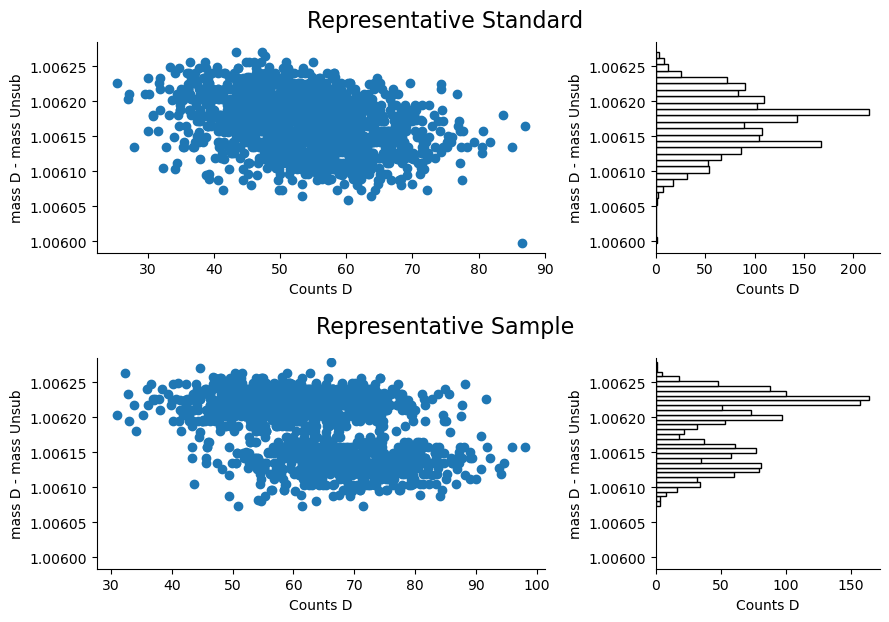

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

fileKeys = list(mergedDict.keys())

fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (9,6), gridspec_kw={'width_ratios': [2, 1]})

cAx = axes[0,0]

cDf = mergedDict[fileKeys[0]][0]

cAx.scatter(cDf['countsD'], cDf['massD'] - cDf['massUnsub'])
cAx.set_ylabel("mass D - mass Unsub")
cAx.set_xlabel("Counts D")

cAx = axes[0,1]

cAx.hist(cDf['massD'] - cDf['massUnsub'], 30, density=False, facecolor='w',edgecolor = 'k', alpha=1, orientation=u'horizontal')
cAx.set_xlabel("Counts D")
cAx.set_ylabel("mass D - mass Unsub")

ylim = cAx.get_ylim()


cAx = axes[1,0]

cDf = mergedDict[fileKeys[3]][0]

cAx.scatter(cDf['countsD'], cDf['massD'] - cDf['massUnsub'])
cAx.set_ylabel("mass D - mass Unsub")
cAx.set_xlabel("Counts D")
cAx.set_ylim(ylim[0], ylim[1])

cAx = axes[1,1]

cAx.hist(cDf['massD'] - cDf['massUnsub'], 30, density=False, facecolor='w',edgecolor = 'k', alpha=1, orientation=u'horizontal')
cAx.set_xlabel("Counts D")
cAx.set_ylabel("mass D - mass Unsub")
cAx.set_ylim(ylim[0], ylim[1])

# Set titles for each row
row_titles = ['Representative Standard', 'Representative Sample']

for i, ax_row in enumerate(axes):
    for ax in ax_row:
        ax.set_title("")  # Clear any default titles
    fig.text(0.5, 1 - 0.51 * i, row_titles[i], ha='center', fontsize=16)

plt.tight_layout()
plt.subplots_adjust(hspace=0.5) 

sns.despine()